Search 1 | BE2 = -0.5 eV, Lambda = (1.107981327394568+0j)
Search 2 | BE2 = -0.6 eV, Lambda = (0.9568965664350514+0j)
Search 3 | BE2 = -0.571470694138042 eV, Lambda = (0.9951838013968826+0j)
Search 4 | BE2 = -0.5678819574957316 eV, Lambda = (1.0002421860252138+0j)
Search 5 | BE2 = -0.5680537795153685 eV, Lambda = (0.9999987024519399+0j)
Search 6 | BE2 = -0.5680528638588203 eV, Lambda = (0.999999999652217+0j)
Search 7 | BE2 = -0.5680528636133302 eV, Lambda = (1.0000000000000018+0j)

Computed Energy: -0.5680528636133302 eV


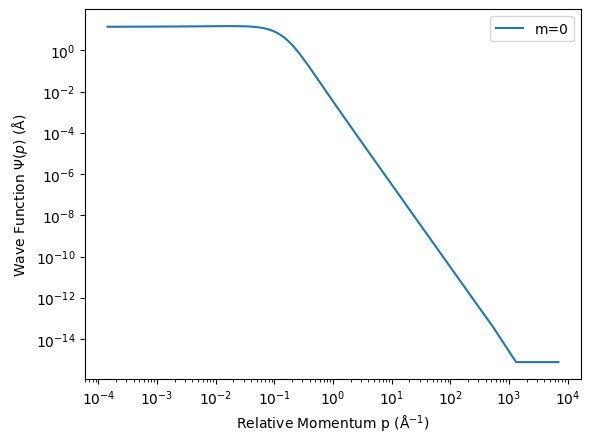

In [ ]:
# This code solves the Schrödinger equation for a 2D two-body system
# using either a Coulomb, Malfliet–Tjon (MT), or custom potential
# in configuration space via the Lippmann–Schwinger (LS) equation.
##
# Author: Mohammadreza Hadizadeh (mhadizadeh@centralstate.edu)
# November 2025.
#
# Please cite the companion article if you use this resource:
# K. Adderley, K. Mohseni, and M. R. Hadizadeh,
# “Open-source interactive website for exciton modeling via the
#  Lippmann–Schwinger equation” (2025),
# URL: https://csu-physics.github.io/2B_2D/.

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
from scipy.special import roots_legendre, jv

# ----------------------------------------------------------------------
# Matplotlib style: more professional / publication-ready defaults
# ----------------------------------------------------------------------
plt.rcParams.update({
    "figure.figsize": (6, 4),
    "figure.dpi": 150,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2,
    "axes.grid": False,
})

# ----------------------------------------------------------------------
# Global numerical parameters and physical constants (user-editable)
# ----------------------------------------------------------------------
Np = 1000            # Number of momentum grid points
Nr = 1000            # Number of radial distance grid points
pi = np.pi
Tol_lambda = 1.0e-10 # Convergence tolerance for eigenvalue Lambda ≈ 1
m_angular = 0        # Orbital angular momentum quantum number (partial wave)

# Choose potential: "coul", "mt", or "custom"
potential_type = "custom"

# Initial binding energy guesses (MeV)
# NOTE: For non-Coulomb potentials, you should adapt these guesses
#       to bracket the expected bound-state energy.
BE2_1 = -1.0   # Lower energy guess
BE2_2 = -4.0   # Upper energy guess

# Momentum and radial ranges for linear grids
P_MAX = 150.0  # Max momentum (fm^-1)
R_MAX = 50.0   # Max radius (fm)

# ----------------------------------------------------------------------
# Helper: mass selection based on potential
# ----------------------------------------------------------------------
def get_mass(potential_type: str) -> float:
    pot = potential_type.lower()
    if pot.startswith("coul"):
        # Atomic-like units: mass = 1
        return 1.0
    elif pot in ("mt", "malfliet-tjon", "malfliet_tjon"):
        # Nuclear physics units: ħ^2 / m ≈ 41.47 MeV·fm^2
        hb2m = 41.47
        return 1.0 / hb2m
    else:  # "custom" or anything else
        # User can adapt this as needed
        return 1.0

# ----------------------------------------------------------------------
# Grids
# ----------------------------------------------------------------------
def hyperbolic(N):
    """
    Non-uniform (hyperbolic) grid in (0, ∞) with Gauss–Legendre mapping.
    """
    X, dX = roots_legendre(N)
    P = (1.0 + X) / (1.0 - X)
    dP = 2.0 / (1.0 - X)**2 * dX
    return P, dP

def linear(N, a, b):
    """
    Linear grid on [a, b] using Gauss–Legendre quadrature (mapped from [-1, 1]).
    """
    X, dX = roots_legendre(N)
    x  = (b - a) / 2 * X + (b + a) / 2
    dx = (b - a) / 2 * dX
    return x, dx

# ----------------------------------------------------------------------
# Eigenvalue solver for the LS kernel
# ----------------------------------------------------------------------
def eigenvalue(Mmatrix):
    """
    Compute eigenvalues/eigenvectors of Mmatrix and return the eigenvector
    corresponding to the eigenvalue closest to 1.
    """
    NEV = 10                    # Number of eigenvalues requested
    NCV = 2 * NEV               # Number of Arnoldi vectors
    WHICH = 'LR'                # Largest real part (targeting Λ ≈ 1)

    eigenvalues, eigenvectors = eigs(Mmatrix, k=NEV, which=WHICH, ncv=NCV)

    target_eigenvalue = 1.0
    idx_min = np.argmin(np.abs(eigenvalues - target_eigenvalue))

    Lambda = eigenvalues[idx_min]
    WF = np.abs(eigenvectors[:, idx_min])  # Remove global phase

    return WF, Lambda

# ----------------------------------------------------------------------
# Potential in configuration space & Fourier–Bessel transform
# ----------------------------------------------------------------------
def build_V_r(r, potential_type):
    """
    Build configuration-space potential V(r) for the chosen type.
    Returns V_r and a metadata dict with parameter info (for printing).
    """
    pot = potential_type.lower()

    if pot.startswith("coul"):
        Z = 2.0
        V_r = -Z / r
        meta = {
            "type": "Coulomb",
            "form": "V(r) = -Z / r",
            "params": {"Z": Z},
        }

    elif pot in ("mt", "malfliet-tjon", "malfliet_tjon"):
        Vr = 1438.72280
        Mr = 3.21
        Va = -600.0
        Ma = 1.550
        V_r = Vr * np.exp(-Mr * r) / r + Va * np.exp(-Ma * r) / r
        meta = {
            "type": "Malfliet–Tjon",
            "form": "V(r) = Vr*exp(-Mr*r)/r + Va*exp(-Ma*r)/r",
            "params": {"Vr": Vr, "Mr": Mr, "Va": Va, "Ma": Ma},
        }

    elif pot == "custom":
        # Example custom potential (user can edit this):
        V0 = -5.0
        a  = 1.0
        V_r = V0 * np.exp(-r**2 / a**2)
        meta = {
            "type": "Custom",
            "form": "User-defined V(r) in build_V_r()",
            "params": {"V0": V0, "a": a},
        }

    else:
        raise ValueError(
            f"Unknown potential_type '{potential_type}'. "
            "Use 'coul', 'mt' (malfliet-tjon), or 'custom'."
        )

    return V_r, meta

def compute_V_2B(p, r, dr, m_angular, potential_type):
    """
    Compute partial-wave projected kernel V_m(p,p'):

        V_m(p,p') = ∫_0^∞ dr r J_m(pr) V(r) J_m(p'r)

    using a radial grid (r, dr).
    """
    Np = p.size
    Nr = r.size

    V_r, meta = build_V_r(r, potential_type)

    # r * V(r) factor in integral
    rV_r = r * V_r
    weight = dr * rV_r   # integration weights times rV_r

    # Bessel matrix: J[ip, ir] = J_m(p[ip] * r[ir])
    J = jv(m_angular, np.outer(p, r))  # shape (Np, Nr)

    # V_m = J @ diag(weight) @ J^T = J @ (J * weight).T
    V_2B_2d = J @ (J * weight).T

    return V_2B_2d, meta

# ----------------------------------------------------------------------
# Lippmann–Schwinger solver
# ----------------------------------------------------------------------
def LS_2D(pp, dp, V_NR, BE2_1, BE2_2, mass):
    """
    Solve the 2D LS equation for a given partial-wave-projected potential V_NR.

    Kernel:
        M(ip, ipp) = dp[ipp] * pp[ipp] * V_NR[ip, ipp] / (E - pp[ip]^2 / mass)
    """
    Np = pp.size
    Ne = 20  # maximum number of iterations

    BE_ary  = np.zeros(Ne)
    Lam_ary = np.zeros(Ne)

    BE_ary[0] = BE2_1
    BE_ary[1] = BE2_2

    for ie in range(Ne):
        if ie > 1:
            BE_ary[ie] = (
                BE_ary[ie-1]
                + (1 - Lam_ary[ie-1])/(Lam_ary[ie-2] - Lam_ary[ie-1])
                * (BE_ary[ie-2] - BE_ary[ie-1])
            )

        BE2 = BE_ary[ie]
        Mmatrix = np.zeros((Np, Np))

        for ip in range(Np):
            denom = BE2 - pp[ip]**2 / mass
            if denom == 0.0:
                continue
            for ipp in range(Np):
                Mmatrix[ip, ipp] = dp[ipp] * pp[ipp] * V_NR[ip, ipp] / denom

        WF, Lambda = eigenvalue(Mmatrix)

        # Normalize wave function: ∫ dp p |ψ(p)|^2 = 1
        WF /= np.sqrt(np.sum(WF**2 * dp * pp))

        Lam_ary[ie] = np.real(Lambda)
        print(f"Search {ie+1} | BE2 = {BE2} MeV, Lambda = {Lambda}")

        if np.abs(Lambda - 1.0) < Tol_lambda:
            break

    return BE2, WF

# ----------------------------------------------------------------------
# Info printer for user-friendliness
# ----------------------------------------------------------------------
def print_potential_info(potential_type, mass, BE2_1, BE2_2, meta):
    print("--------------------------------------------------")
    print(" Selected two-body potential and numerical setup")
    print("--------------------------------------------------")
    print(f"Potential type : {meta.get('type', 'Unknown')}")
    print(f"Form           : {meta.get('form', 'N/A')}")
    if "params" in meta:
        print("Parameters     :")
        for key, val in meta["params"].items():
            print(f"    {key} = {val}")
    print(f"Mass parameter : m = {mass:.6e} (in chosen units)")
    print(f"Initial energy guesses: BE2_1 = {BE2_1} MeV, BE2_2 = {BE2_2} MeV")
    print("NOTE: Make sure BE2_1 and BE2_2 bracket the expected bound-state")
    print("      energy for the chosen potential.\n")

# ----------------------------------------------------------------------
# Main program
# ----------------------------------------------------------------------
def main():
    # Build grids (you can switch to hyperbolic if desired)
    p, dp = linear(Np, 0.0, P_MAX)
    r, dr = linear(Nr, 0.0, R_MAX)

    # Mass based on chosen potential
    mass = get_mass(potential_type)

    # Potential in momentum space
    V_2B_2d, meta = compute_V_2B(p, r, dr, m_angular, potential_type)

    # Print configuration info
    print_potential_info(potential_type, mass, BE2_1, BE2_2, meta)

    WF_matrix = []

    # For now, single partial wave m_angular
    for n in range(0, m_angular + 1):
        BE2, WF = LS_2D(p, dp, V_2B_2d, BE2_1, BE2_2, mass)
        WF_matrix.append(WF)

        print(f"\nComputed Binding Energy (m={m_angular}): {BE2} MeV\n")

        # Plot |Ψ(p)|
        fig, ax = plt.subplots()
        ax.loglog(p, np.abs(WF), label=f'm={m_angular}')
        ax.set_xlabel(r'Relative momentum $p$ (fm$^{-1}$)')
        ax.set_ylabel(r'Wave function $|\Psi(p)|$')
        ax.legend(frameon=False)
        fig.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()